In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
from scipy import signal
import os 
import pandas as pd
import wandb
from wandb.keras import WandbCallback

2023-12-26 13:37:41.894894: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-26 13:37:41.944591: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-26 13:37:41.944631: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-26 13:37:41.944661: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-26 13:37:41.954242: I tensorflow/core/platform/cpu_feature_g

## Data Loading

In [18]:
x_train=np.load('../BraiNeoCare/Datasets/balanced_x_train_common_4s.npy', mmap_mode='r')
x_test=np.load('../BraiNeoCare/Datasets/balanced_x_test_common_4s.npy', mmap_mode='r')
y_train=np.load('../BraiNeoCare/Datasets/balanced_y_train_common_4s.npy', mmap_mode='r')
y_test=np.load('../BraiNeoCare/Datasets/balanced_y_test_common_4s.npy', mmap_mode='r')

In [3]:
# sos=signal.butter(2,[0.5,100],btype='bandpass',fs=256,output='sos')    

In [4]:
# x_train=signal.sosfilt(sos,x_train,axis=1)
# x_test=signal.sosfilt(sos,x_test,axis=1)

In [19]:
mean=x_train.mean()
std=x_train.std()
x_train=(x_train-mean)/std
x_test=(x_test-mean)/std

In [20]:
#shuffle the data
np.random.seed(42)
train_indices = np.arange(x_train.shape[0])
np.random.shuffle(train_indices)
x_train = x_train[train_indices].reshape(x_train.shape[0],1024,12)
y_train = y_train[train_indices]
test_indices = np.arange(x_test.shape[0])   
np.random.shuffle(test_indices)
x_test = x_test[test_indices].reshape(x_test.shape[0],1024,12)
y_test = y_test[test_indices]

In [ ]:
# x_train=x_train*(10**5)
# x_test=x_test*(10**5)

In [22]:
x_test.shape

(4024, 1024, 12)

## Tiny model

In [14]:
'''For 4s partitions I used dropout=0.25, and learning rate=0.0025, and weight decay=0.01. Saved model is best_model_for_4s_1.h5 was taken
after 500 epoch with batch size=128'''

Input=keras.Input(shape=(1024,12),name="Input_signal")
x=layers.Conv1D(32,3,padding="same",activation='swish')(Input)
y=layers.Conv1D(32,7,padding='same',activation='swish')(Input)
a=layers.add([x,y])
x=layers.MaxPooling1D(4)(a)
x=layers.SpatialDropout1D(0.25)(x) 

x=layers.Conv1D(64,3,padding="same",activation='swish')(x)   
y=layers.Conv1D(64,7,padding='same',activation='swish')(x)#new
a=layers.add([x,y])#new

x=layers.GlobalAveragePooling1D()(a)
x=layers.Dropout(0.25)(x)
x=layers.Dense(32,activation='swish')(x) 
x=layers.Dense(16,activation='swish')(x)
x=layers.Dense(1,activation='sigmoid')(x)

model1=keras.Model(inputs=Input,outputs=x)

optimizer=keras.optimizers.Adam(learning_rate=0.0025,weight_decay=0.01)

F1=keras.metrics.F1Score(threshold=0.5, name='F1', dtype=None) 
precall = keras.metrics.Precision()
recall = keras.metrics.Recall()
AUROC = keras.metrics.AUC(curve='ROC', name = 'AUROC')
AUPRC = keras.metrics.AUC(curve='PR', name = 'AUPRC')
model1.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy',F1, AUROC, AUPRC, precall, recall])

In [ ]:
model1.summary()

In [15]:
checkpoint_path='Saved_model_weights_9/cp_{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

In [16]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max',)
cp_callback = ModelCheckpoint(filepath=checkpoint_path,monitor="val_loss",save_weights_only=False,verbose=0,save_best_only=True)
# def lrschedule(epoch,lr):
#     if (epoch%50==0 and epoch!=0):
#         return lr*0.9
#     else:
#         return lr
# LRscheduler=LearningRateScheduler(lrschedule,verbose=0) w

history=model1.fit(x_train,y_train,epochs=500,batch_size=128,validation_data=(x_test,y_test),callbacks=[cp_callback])

Epoch 1/500
118/118 [==============================] - ETA: 0s - loss: 0.6177 - accuracy: 0.6648 - F1: 0.7056 - AUROC: 0.7240 - AUPRC: 0.7524 - precision_2: 0.6675 - recall_2: 0.7484INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0001.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0001.ckpt/assets


118/118 [==============================] - 9s 44ms/step - loss: 0.6177 - accuracy: 0.6648 - F1: 0.7056 - AUROC: 0.7240 - AUPRC: 0.7524 - precision_2: 0.6675 - recall_2: 0.7484 - val_loss: 0.5568 - val_accuracy: 0.7117 - val_F1: 0.7316 - val_AUROC: 0.7919 - val_AUPRC: 0.8086 - val_precision_2: 0.6844 - val_recall_2: 0.7858
Epoch 2/500
117/118 [============================>.] - ETA: 0s - loss: 0.5549 - accuracy: 0.7133 - F1: 0.7321 - AUROC: 0.7852 - AUPRC: 0.8138 - precision_2: 0.7346 - recall_2: 0.7296INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0002.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0002.ckpt/assets


118/118 [==============================] - 5s 43ms/step - loss: 0.5548 - accuracy: 0.7134 - F1: 0.7322 - AUROC: 0.7853 - AUPRC: 0.8140 - precision_2: 0.7346 - recall_2: 0.7298 - val_loss: 0.5258 - val_accuracy: 0.7269 - val_F1: 0.7113 - val_AUROC: 0.8134 - val_AUPRC: 0.8304 - val_precision_2: 0.7543 - val_recall_2: 0.6730
Epoch 3/500
117/118 [============================>.] - ETA: 0s - loss: 0.5282 - accuracy: 0.7238 - F1: 0.7412 - AUROC: 0.8082 - AUPRC: 0.8392 - precision_2: 0.7454 - recall_2: 0.7370INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0003.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0003.ckpt/assets


118/118 [==============================] - 4s 37ms/step - loss: 0.5284 - accuracy: 0.7237 - F1: 0.7412 - AUROC: 0.8080 - AUPRC: 0.8391 - precision_2: 0.7453 - recall_2: 0.7371 - val_loss: 0.5082 - val_accuracy: 0.7336 - val_F1: 0.7301 - val_AUROC: 0.8206 - val_AUPRC: 0.8402 - val_precision_2: 0.7398 - val_recall_2: 0.7207
Epoch 4/500
115/118 [============================>.] - ETA: 0s - loss: 0.5178 - accuracy: 0.7287 - F1: 0.7443 - AUROC: 0.8139 - AUPRC: 0.8459 - precision_2: 0.7531 - recall_2: 0.7358INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0004.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0004.ckpt/assets


118/118 [==============================] - 4s 36ms/step - loss: 0.5186 - accuracy: 0.7284 - F1: 0.7433 - AUROC: 0.8136 - AUPRC: 0.8454 - precision_2: 0.7545 - recall_2: 0.7324 - val_loss: 0.5040 - val_accuracy: 0.7411 - val_F1: 0.7338 - val_AUROC: 0.8263 - val_AUPRC: 0.8471 - val_precision_2: 0.7550 - val_recall_2: 0.7137
Epoch 5/500
118/118 [==============================] - 2s 21ms/step - loss: 0.5088 - accuracy: 0.7335 - F1: 0.7499 - AUROC: 0.8217 - AUPRC: 0.8525 - precision_2: 0.7555 - recall_2: 0.7444 - val_loss: 0.5056 - val_accuracy: 0.7408 - val_F1: 0.7319 - val_AUROC: 0.8223 - val_AUPRC: 0.8429 - val_precision_2: 0.7578 - val_recall_2: 0.7078
Epoch 6/500
117/118 [============================>.] - ETA: 0s - loss: 0.5017 - accuracy: 0.7359 - F1: 0.7484 - AUROC: 0.8255 - AUPRC: 0.8581 - precision_2: 0.7659 - recall_2: 0.7316INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0006.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0006.ckpt/assets


118/118 [==============================] - 4s 35ms/step - loss: 0.5018 - accuracy: 0.7359 - F1: 0.7483 - AUROC: 0.8254 - AUPRC: 0.8581 - precision_2: 0.7659 - recall_2: 0.7315 - val_loss: 0.4974 - val_accuracy: 0.7445 - val_F1: 0.7566 - val_AUROC: 0.8336 - val_AUPRC: 0.8522 - val_precision_2: 0.7224 - val_recall_2: 0.7942
Epoch 7/500
115/118 [============================>.] - ETA: 0s - loss: 0.4983 - accuracy: 0.7412 - F1: 0.7539 - AUROC: 0.8279 - AUPRC: 0.8605 - precision_2: 0.7696 - recall_2: 0.7387INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0007.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0007.ckpt/assets


118/118 [==============================] - 4s 37ms/step - loss: 0.4979 - accuracy: 0.7418 - F1: 0.7546 - AUROC: 0.8283 - AUPRC: 0.8610 - precision_2: 0.7703 - recall_2: 0.7396 - val_loss: 0.4806 - val_accuracy: 0.7495 - val_F1: 0.7409 - val_AUROC: 0.8406 - val_AUPRC: 0.8610 - val_precision_2: 0.7673 - val_recall_2: 0.7162
Epoch 8/500
118/118 [==============================] - 2s 20ms/step - loss: 0.4884 - accuracy: 0.7439 - F1: 0.7560 - AUROC: 0.8355 - AUPRC: 0.8672 - precision_2: 0.7739 - recall_2: 0.7388 - val_loss: 0.4929 - val_accuracy: 0.7388 - val_F1: 0.7546 - val_AUROC: 0.8411 - val_AUPRC: 0.8619 - val_precision_2: 0.7116 - val_recall_2: 0.8032
Epoch 9/500
118/118 [==============================] - 2s 20ms/step - loss: 0.4843 - accuracy: 0.7469 - F1: 0.7573 - AUROC: 0.8385 - AUPRC: 0.8697 - precision_2: 0.7805 - recall_2: 0.7353 - val_loss: 0.4913 - val_accuracy: 0.7448 - val_F1: 0.7574 - val_AUROC: 0.8417 - val_AUPRC: 0.8629 - val_precision_2: 0.7217 - val_recall_2: 0.7967
Epoc

INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0011.ckpt/assets


118/118 [==============================] - 4s 36ms/step - loss: 0.4815 - accuracy: 0.7523 - F1: 0.7650 - AUROC: 0.8416 - AUPRC: 0.8719 - precision_2: 0.7796 - recall_2: 0.7509 - val_loss: 0.4791 - val_accuracy: 0.7599 - val_F1: 0.7399 - val_AUROC: 0.8463 - val_AUPRC: 0.8664 - val_precision_2: 0.8073 - val_recall_2: 0.6829
Epoch 12/500
117/118 [============================>.] - ETA: 0s - loss: 0.4783 - accuracy: 0.7527 - F1: 0.7643 - AUROC: 0.8438 - AUPRC: 0.8745 - precision_2: 0.7824 - recall_2: 0.7470INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0012.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0012.ckpt/assets


118/118 [==============================] - 5s 46ms/step - loss: 0.4784 - accuracy: 0.7526 - F1: 0.7642 - AUROC: 0.8436 - AUPRC: 0.8745 - precision_2: 0.7824 - recall_2: 0.7469 - val_loss: 0.4648 - val_accuracy: 0.7639 - val_F1: 0.7554 - val_AUROC: 0.8513 - val_AUPRC: 0.8705 - val_precision_2: 0.7837 - val_recall_2: 0.7291
Epoch 13/500
117/118 [============================>.] - ETA: 0s - loss: 0.4780 - accuracy: 0.7564 - F1: 0.7678 - AUROC: 0.8458 - AUPRC: 0.8751 - precision_2: 0.7864 - recall_2: 0.7500INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0013.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0013.ckpt/assets


118/118 [==============================] - 4s 36ms/step - loss: 0.4779 - accuracy: 0.7565 - F1: 0.7678 - AUROC: 0.8459 - AUPRC: 0.8751 - precision_2: 0.7864 - recall_2: 0.7501 - val_loss: 0.4604 - val_accuracy: 0.7676 - val_F1: 0.7634 - val_AUROC: 0.8555 - val_AUPRC: 0.8744 - val_precision_2: 0.7777 - val_recall_2: 0.7495
Epoch 14/500
118/118 [==============================] - 3s 22ms/step - loss: 0.4698 - accuracy: 0.7597 - F1: 0.7702 - AUROC: 0.8490 - AUPRC: 0.8793 - precision_2: 0.7913 - recall_2: 0.7502 - val_loss: 0.4695 - val_accuracy: 0.7632 - val_F1: 0.7555 - val_AUROC: 0.8545 - val_AUPRC: 0.8744 - val_precision_2: 0.7809 - val_recall_2: 0.7316
Epoch 15/500
115/118 [============================>.] - ETA: 0s - loss: 0.4703 - accuracy: 0.7622 - F1: 0.7745 - AUROC: 0.8511 - AUPRC: 0.8803 - precision_2: 0.7883 - recall_2: 0.7611INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0015.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0015.ckpt/assets


118/118 [==============================] - 4s 36ms/step - loss: 0.4700 - accuracy: 0.7626 - F1: 0.7748 - AUROC: 0.8512 - AUPRC: 0.8806 - precision_2: 0.7893 - recall_2: 0.7608 - val_loss: 0.4549 - val_accuracy: 0.7746 - val_F1: 0.7680 - val_AUROC: 0.8590 - val_AUPRC: 0.8780 - val_precision_2: 0.7912 - val_recall_2: 0.7460
Epoch 16/500
116/118 [============================>.] - ETA: 0s - loss: 0.4567 - accuracy: 0.7705 - F1: 0.7817 - AUROC: 0.8596 - AUPRC: 0.8879 - precision_2: 0.7991 - recall_2: 0.7650INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0016.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0016.ckpt/assets


118/118 [==============================] - 4s 36ms/step - loss: 0.4571 - accuracy: 0.7702 - F1: 0.7814 - AUROC: 0.8593 - AUPRC: 0.8875 - precision_2: 0.7984 - recall_2: 0.7652 - val_loss: 0.4504 - val_accuracy: 0.7751 - val_F1: 0.7787 - val_AUROC: 0.8670 - val_AUPRC: 0.8843 - val_precision_2: 0.7665 - val_recall_2: 0.7913
Epoch 17/500
116/118 [============================>.] - ETA: 0s - loss: 0.4454 - accuracy: 0.7784 - F1: 0.7884 - AUROC: 0.8670 - AUPRC: 0.8944 - precision_2: 0.8088 - recall_2: 0.7691INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0017.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0017.ckpt/assets


118/118 [==============================] - 4s 36ms/step - loss: 0.4448 - accuracy: 0.7786 - F1: 0.7887 - AUROC: 0.8674 - AUPRC: 0.8947 - precision_2: 0.8087 - recall_2: 0.7696 - val_loss: 0.4286 - val_accuracy: 0.7952 - val_F1: 0.7974 - val_AUROC: 0.8798 - val_AUPRC: 0.8963 - val_precision_2: 0.7889 - val_recall_2: 0.8062
Epoch 18/500
118/118 [==============================] - ETA: 0s - loss: 0.4475 - accuracy: 0.7814 - F1: 0.7926 - AUROC: 0.8672 - AUPRC: 0.8939 - precision_2: 0.8076 - recall_2: 0.7782INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0018.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0018.ckpt/assets


118/118 [==============================] - 4s 36ms/step - loss: 0.4475 - accuracy: 0.7814 - F1: 0.7926 - AUROC: 0.8672 - AUPRC: 0.8939 - precision_2: 0.8076 - recall_2: 0.7782 - val_loss: 0.4176 - val_accuracy: 0.8037 - val_F1: 0.7950 - val_AUROC: 0.8860 - val_AUPRC: 0.9024 - val_precision_2: 0.8317 - val_recall_2: 0.7614
Epoch 19/500
118/118 [==============================] - 3s 22ms/step - loss: 0.4284 - accuracy: 0.7950 - F1: 0.8048 - AUROC: 0.8787 - AUPRC: 0.9046 - precision_2: 0.8231 - recall_2: 0.7874 - val_loss: 0.4187 - val_accuracy: 0.8029 - val_F1: 0.7832 - val_AUROC: 0.8874 - val_AUPRC: 0.9031 - val_precision_2: 0.8705 - val_recall_2: 0.7117
Epoch 20/500
117/118 [============================>.] - ETA: 0s - loss: 0.4185 - accuracy: 0.7993 - F1: 0.8067 - AUROC: 0.8853 - AUPRC: 0.9102 - precision_2: 0.8352 - recall_2: 0.7800INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0020.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0020.ckpt/assets


118/118 [==============================] - 5s 44ms/step - loss: 0.4185 - accuracy: 0.7994 - F1: 0.8067 - AUROC: 0.8853 - AUPRC: 0.9103 - precision_2: 0.8354 - recall_2: 0.7799 - val_loss: 0.4002 - val_accuracy: 0.8141 - val_F1: 0.8036 - val_AUROC: 0.8944 - val_AUPRC: 0.9099 - val_precision_2: 0.8519 - val_recall_2: 0.7604
Epoch 21/500
117/118 [============================>.] - ETA: 0s - loss: 0.4076 - accuracy: 0.8096 - F1: 0.8174 - AUROC: 0.8909 - AUPRC: 0.9156 - precision_2: 0.8419 - recall_2: 0.7943INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0021.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0021.ckpt/assets


118/118 [==============================] - 4s 36ms/step - loss: 0.4072 - accuracy: 0.8099 - F1: 0.8178 - AUROC: 0.8911 - AUPRC: 0.9159 - precision_2: 0.8422 - recall_2: 0.7947 - val_loss: 0.3894 - val_accuracy: 0.8196 - val_F1: 0.8142 - val_AUROC: 0.9013 - val_AUPRC: 0.9141 - val_precision_2: 0.8391 - val_recall_2: 0.7908
Epoch 22/500
117/118 [============================>.] - ETA: 0s - loss: 0.3994 - accuracy: 0.8090 - F1: 0.8164 - AUROC: 0.8952 - AUPRC: 0.9186 - precision_2: 0.8440 - recall_2: 0.7905INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0022.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0022.ckpt/assets


118/118 [==============================] - 4s 36ms/step - loss: 0.3993 - accuracy: 0.8091 - F1: 0.8164 - AUROC: 0.8953 - AUPRC: 0.9186 - precision_2: 0.8441 - recall_2: 0.7905 - val_loss: 0.3813 - val_accuracy: 0.8263 - val_F1: 0.8132 - val_AUROC: 0.9056 - val_AUPRC: 0.9187 - val_precision_2: 0.8797 - val_recall_2: 0.7560
Epoch 23/500
118/118 [==============================] - 2s 20ms/step - loss: 0.3943 - accuracy: 0.8147 - F1: 0.8212 - AUROC: 0.8975 - AUPRC: 0.9218 - precision_2: 0.8516 - recall_2: 0.7930 - val_loss: 0.3882 - val_accuracy: 0.8238 - val_F1: 0.8245 - val_AUROC: 0.9057 - val_AUPRC: 0.9188 - val_precision_2: 0.8211 - val_recall_2: 0.8280
Epoch 24/500
116/118 [============================>.] - ETA: 0s - loss: 0.3992 - accuracy: 0.8141 - F1: 0.8202 - AUROC: 0.8968 - AUPRC: 0.9204 - precision_2: 0.8531 - recall_2: 0.7898INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0024.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0024.ckpt/assets


118/118 [==============================] - 4s 36ms/step - loss: 0.3986 - accuracy: 0.8144 - F1: 0.8205 - AUROC: 0.8971 - AUPRC: 0.9206 - precision_2: 0.8532 - recall_2: 0.7902 - val_loss: 0.3783 - val_accuracy: 0.8250 - val_F1: 0.8229 - val_AUROC: 0.9067 - val_AUPRC: 0.9204 - val_precision_2: 0.8330 - val_recall_2: 0.8131
Epoch 25/500
116/118 [============================>.] - ETA: 0s - loss: 0.3825 - accuracy: 0.8223 - F1: 0.8289 - AUROC: 0.9046 - AUPRC: 0.9263 - precision_2: 0.8583 - recall_2: 0.8014INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0025.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0025.ckpt/assets


118/118 [==============================] - 4s 35ms/step - loss: 0.3836 - accuracy: 0.8216 - F1: 0.8281 - AUROC: 0.9040 - AUPRC: 0.9258 - precision_2: 0.8578 - recall_2: 0.8003 - val_loss: 0.3724 - val_accuracy: 0.8285 - val_F1: 0.8299 - val_AUROC: 0.9132 - val_AUPRC: 0.9257 - val_precision_2: 0.8234 - val_recall_2: 0.8365
Epoch 26/500
116/118 [============================>.] - ETA: 0s - loss: 0.3790 - accuracy: 0.8233 - F1: 0.8295 - AUROC: 0.9059 - AUPRC: 0.9280 - precision_2: 0.8600 - recall_2: 0.8011INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0026.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0026.ckpt/assets


118/118 [==============================] - 4s 36ms/step - loss: 0.3795 - accuracy: 0.8233 - F1: 0.8296 - AUROC: 0.9058 - AUPRC: 0.9279 - precision_2: 0.8603 - recall_2: 0.8009 - val_loss: 0.3687 - val_accuracy: 0.8328 - val_F1: 0.8242 - val_AUROC: 0.9107 - val_AUPRC: 0.9237 - val_precision_2: 0.8685 - val_recall_2: 0.7843
Epoch 27/500
118/118 [==============================] - ETA: 0s - loss: 0.3693 - accuracy: 0.8286 - F1: 0.8346 - AUROC: 0.9109 - AUPRC: 0.9321 - precision_2: 0.8656 - recall_2: 0.8058INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0027.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0027.ckpt/assets


118/118 [==============================] - 5s 44ms/step - loss: 0.3693 - accuracy: 0.8286 - F1: 0.8346 - AUROC: 0.9109 - AUPRC: 0.9321 - precision_2: 0.8656 - recall_2: 0.8058 - val_loss: 0.3605 - val_accuracy: 0.8417 - val_F1: 0.8309 - val_AUROC: 0.9151 - val_AUPRC: 0.9279 - val_precision_2: 0.8917 - val_recall_2: 0.7778
Epoch 28/500
118/118 [==============================] - 2s 20ms/step - loss: 0.3740 - accuracy: 0.8251 - F1: 0.8309 - AUROC: 0.9088 - AUPRC: 0.9303 - precision_2: 0.8637 - recall_2: 0.8005 - val_loss: 0.3751 - val_accuracy: 0.8273 - val_F1: 0.8328 - val_AUROC: 0.9163 - val_AUPRC: 0.9289 - val_precision_2: 0.8070 - val_recall_2: 0.8603
Epoch 29/500
118/118 [==============================] - 2s 20ms/step - loss: 0.3786 - accuracy: 0.8261 - F1: 0.8317 - AUROC: 0.9074 - AUPRC: 0.9286 - precision_2: 0.8653 - recall_2: 0.8007 - val_loss: 0.3757 - val_accuracy: 0.8335 - val_F1: 0.8151 - val_AUROC: 0.9124 - val_AUPRC: 0.9276 - val_precision_2: 0.9163 - val_recall_2: 0.7341
Ep

INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0031.ckpt/assets


118/118 [==============================] - 4s 38ms/step - loss: 0.3633 - accuracy: 0.8327 - F1: 0.8387 - AUROC: 0.9144 - AUPRC: 0.9345 - precision_2: 0.8692 - recall_2: 0.8102 - val_loss: 0.3446 - val_accuracy: 0.8499 - val_F1: 0.8451 - val_AUROC: 0.9227 - val_AUPRC: 0.9346 - val_precision_2: 0.8729 - val_recall_2: 0.8191
Epoch 32/500
118/118 [==============================] - 2s 20ms/step - loss: 0.3550 - accuracy: 0.8357 - F1: 0.8418 - AUROC: 0.9180 - AUPRC: 0.9375 - precision_2: 0.8710 - recall_2: 0.8145 - val_loss: 0.3473 - val_accuracy: 0.8449 - val_F1: 0.8343 - val_AUROC: 0.9212 - val_AUPRC: 0.9338 - val_precision_2: 0.8957 - val_recall_2: 0.7808
Epoch 33/500
118/118 [==============================] - 2s 20ms/step - loss: 0.3556 - accuracy: 0.8381 - F1: 0.8439 - AUROC: 0.9177 - AUPRC: 0.9376 - precision_2: 0.8750 - recall_2: 0.8148 - val_loss: 0.3477 - val_accuracy: 0.8449 - val_F1: 0.8334 - val_AUROC: 0.9211 - val_AUPRC: 0.9349 - val_precision_2: 0.9002 - val_recall_2: 0.7758
Ep

INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0036.ckpt/assets


118/118 [==============================] - 4s 36ms/step - loss: 0.3433 - accuracy: 0.8427 - F1: 0.8489 - AUROC: 0.9237 - AUPRC: 0.9417 - precision_2: 0.8761 - recall_2: 0.8234 - val_loss: 0.3318 - val_accuracy: 0.8539 - val_F1: 0.8529 - val_AUROC: 0.9300 - val_AUPRC: 0.9407 - val_precision_2: 0.8589 - val_recall_2: 0.8469
Epoch 37/500
118/118 [==============================] - 2s 20ms/step - loss: 0.3429 - accuracy: 0.8450 - F1: 0.8512 - AUROC: 0.9237 - AUPRC: 0.9419 - precision_2: 0.8781 - recall_2: 0.8259 - val_loss: 0.3367 - val_accuracy: 0.8482 - val_F1: 0.8373 - val_AUROC: 0.9254 - val_AUPRC: 0.9384 - val_precision_2: 0.9019 - val_recall_2: 0.7813
Epoch 38/500
115/118 [============================>.] - ETA: 0s - loss: 0.3379 - accuracy: 0.8486 - F1: 0.8539 - AUROC: 0.9266 - AUPRC: 0.9436 - precision_2: 0.8851 - recall_2: 0.8249INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0038.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0038.ckpt/assets


118/118 [==============================] - 4s 36ms/step - loss: 0.3387 - accuracy: 0.8477 - F1: 0.8533 - AUROC: 0.9262 - AUPRC: 0.9433 - precision_2: 0.8836 - recall_2: 0.8250 - val_loss: 0.3264 - val_accuracy: 0.8588 - val_F1: 0.8484 - val_AUROC: 0.9297 - val_AUPRC: 0.9430 - val_precision_2: 0.9164 - val_recall_2: 0.7898
Epoch 39/500
118/118 [==============================] - 2s 21ms/step - loss: 0.3366 - accuracy: 0.8477 - F1: 0.8531 - AUROC: 0.9263 - AUPRC: 0.9445 - precision_2: 0.8847 - recall_2: 0.8236 - val_loss: 0.3318 - val_accuracy: 0.8511 - val_F1: 0.8440 - val_AUROC: 0.9273 - val_AUPRC: 0.9393 - val_precision_2: 0.8867 - val_recall_2: 0.8052
Epoch 40/500
118/118 [==============================] - 2s 21ms/step - loss: 0.3317 - accuracy: 0.8511 - F1: 0.8565 - AUROC: 0.9287 - AUPRC: 0.9458 - precision_2: 0.8877 - recall_2: 0.8274 - val_loss: 0.3368 - val_accuracy: 0.8526 - val_F1: 0.8393 - val_AUROC: 0.9294 - val_AUPRC: 0.9406 - val_precision_2: 0.9226 - val_recall_2: 0.7699
Ep

INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0042.ckpt/assets


118/118 [==============================] - 4s 37ms/step - loss: 0.3247 - accuracy: 0.8537 - F1: 0.8592 - AUROC: 0.9320 - AUPRC: 0.9483 - precision_2: 0.8882 - recall_2: 0.8321 - val_loss: 0.3208 - val_accuracy: 0.8621 - val_F1: 0.8609 - val_AUROC: 0.9346 - val_AUPRC: 0.9450 - val_precision_2: 0.8681 - val_recall_2: 0.8539
Epoch 43/500
117/118 [============================>.] - ETA: 0s - loss: 0.3250 - accuracy: 0.8533 - F1: 0.8591 - AUROC: 0.9313 - AUPRC: 0.9482 - precision_2: 0.8866 - recall_2: 0.8333INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0043.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0043.ckpt/assets


118/118 [==============================] - 4s 36ms/step - loss: 0.3249 - accuracy: 0.8533 - F1: 0.8592 - AUROC: 0.9314 - AUPRC: 0.9483 - precision_2: 0.8866 - recall_2: 0.8333 - val_loss: 0.3132 - val_accuracy: 0.8675 - val_F1: 0.8617 - val_AUROC: 0.9369 - val_AUPRC: 0.9475 - val_precision_2: 0.9017 - val_recall_2: 0.8250
Epoch 44/500
118/118 [==============================] - ETA: 0s - loss: 0.3256 - accuracy: 0.8578 - F1: 0.8630 - AUROC: 0.9313 - AUPRC: 0.9480 - precision_2: 0.8937 - recall_2: 0.8343INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0044.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0044.ckpt/assets


118/118 [==============================] - 4s 36ms/step - loss: 0.3256 - accuracy: 0.8578 - F1: 0.8630 - AUROC: 0.9313 - AUPRC: 0.9480 - precision_2: 0.8937 - recall_2: 0.8343 - val_loss: 0.3100 - val_accuracy: 0.8641 - val_F1: 0.8565 - val_AUROC: 0.9379 - val_AUPRC: 0.9478 - val_precision_2: 0.9067 - val_recall_2: 0.8116
Epoch 45/500
118/118 [==============================] - 3s 23ms/step - loss: 0.3223 - accuracy: 0.8564 - F1: 0.8617 - AUROC: 0.9335 - AUPRC: 0.9489 - precision_2: 0.8920 - recall_2: 0.8333 - val_loss: 0.3387 - val_accuracy: 0.8449 - val_F1: 0.8511 - val_AUROC: 0.9363 - val_AUPRC: 0.9463 - val_precision_2: 0.8183 - val_recall_2: 0.8867
Epoch 46/500
118/118 [==============================] - 2s 21ms/step - loss: 0.3154 - accuracy: 0.8622 - F1: 0.8678 - AUROC: 0.9360 - AUPRC: 0.9512 - precision_2: 0.8948 - recall_2: 0.8423 - val_loss: 0.3289 - val_accuracy: 0.8544 - val_F1: 0.8573 - val_AUROC: 0.9348 - val_AUPRC: 0.9449 - val_precision_2: 0.8405 - val_recall_2: 0.8748
Ep

INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0047.ckpt/assets


118/118 [==============================] - 5s 45ms/step - loss: 0.3231 - accuracy: 0.8561 - F1: 0.8618 - AUROC: 0.9329 - AUPRC: 0.9491 - precision_2: 0.8899 - recall_2: 0.8353 - val_loss: 0.3074 - val_accuracy: 0.8661 - val_F1: 0.8566 - val_AUROC: 0.9398 - val_AUPRC: 0.9497 - val_precision_2: 0.9216 - val_recall_2: 0.8002
Epoch 48/500
116/118 [============================>.] - ETA: 0s - loss: 0.3183 - accuracy: 0.8603 - F1: 0.8657 - AUROC: 0.9348 - AUPRC: 0.9503 - precision_2: 0.8947 - recall_2: 0.8386INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0048.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0048.ckpt/assets


118/118 [==============================] - 4s 37ms/step - loss: 0.3180 - accuracy: 0.8605 - F1: 0.8658 - AUROC: 0.9349 - AUPRC: 0.9504 - precision_2: 0.8951 - recall_2: 0.8384 - val_loss: 0.2994 - val_accuracy: 0.8698 - val_F1: 0.8629 - val_AUROC: 0.9416 - val_AUPRC: 0.9509 - val_precision_2: 0.9110 - val_recall_2: 0.8196
Epoch 49/500
118/118 [==============================] - 3s 21ms/step - loss: 0.3160 - accuracy: 0.8574 - F1: 0.8632 - AUROC: 0.9355 - AUPRC: 0.9511 - precision_2: 0.8897 - recall_2: 0.8383 - val_loss: 0.3228 - val_accuracy: 0.8593 - val_F1: 0.8442 - val_AUROC: 0.9377 - val_AUPRC: 0.9487 - val_precision_2: 0.9463 - val_recall_2: 0.7619
Epoch 50/500
118/118 [==============================] - 2s 20ms/step - loss: 0.3132 - accuracy: 0.8609 - F1: 0.8663 - AUROC: 0.9373 - AUPRC: 0.9518 - precision_2: 0.8949 - recall_2: 0.8394 - val_loss: 0.3241 - val_accuracy: 0.8648 - val_F1: 0.8549 - val_AUROC: 0.9329 - val_AUPRC: 0.9453 - val_precision_2: 0.9223 - val_recall_2: 0.7967
Ep

INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0053.ckpt/assets


118/118 [==============================] - 4s 37ms/step - loss: 0.3056 - accuracy: 0.8630 - F1: 0.8683 - AUROC: 0.9392 - AUPRC: 0.9546 - precision_2: 0.8968 - recall_2: 0.8417 - val_loss: 0.2925 - val_accuracy: 0.8777 - val_F1: 0.8727 - val_AUROC: 0.9435 - val_AUPRC: 0.9526 - val_precision_2: 0.9099 - val_recall_2: 0.8385
Epoch 54/500
118/118 [==============================] - 2s 21ms/step - loss: 0.3057 - accuracy: 0.8673 - F1: 0.8721 - AUROC: 0.9394 - AUPRC: 0.9544 - precision_2: 0.9035 - recall_2: 0.8429 - val_loss: 0.3038 - val_accuracy: 0.8675 - val_F1: 0.8568 - val_AUROC: 0.9409 - val_AUPRC: 0.9514 - val_precision_2: 0.9322 - val_recall_2: 0.7927
Epoch 55/500
118/118 [==============================] - 3s 21ms/step - loss: 0.2973 - accuracy: 0.8714 - F1: 0.8765 - AUROC: 0.9437 - AUPRC: 0.9567 - precision_2: 0.9048 - recall_2: 0.8499 - val_loss: 0.2972 - val_accuracy: 0.8700 - val_F1: 0.8665 - val_AUROC: 0.9419 - val_AUPRC: 0.9517 - val_precision_2: 0.8904 - val_recall_2: 0.8439
Ep

INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0058.ckpt/assets


118/118 [==============================] - 4s 36ms/step - loss: 0.2954 - accuracy: 0.8693 - F1: 0.8748 - AUROC: 0.9442 - AUPRC: 0.9574 - precision_2: 0.9001 - recall_2: 0.8508 - val_loss: 0.2888 - val_accuracy: 0.8740 - val_F1: 0.8706 - val_AUROC: 0.9449 - val_AUPRC: 0.9544 - val_precision_2: 0.8946 - val_recall_2: 0.8479
Epoch 59/500
118/118 [==============================] - 2s 20ms/step - loss: 0.2940 - accuracy: 0.8721 - F1: 0.8776 - AUROC: 0.9447 - AUPRC: 0.9579 - precision_2: 0.9020 - recall_2: 0.8546 - val_loss: 0.3068 - val_accuracy: 0.8690 - val_F1: 0.8561 - val_AUROC: 0.9456 - val_AUPRC: 0.9550 - val_precision_2: 0.9497 - val_recall_2: 0.7793
Epoch 60/500
118/118 [==============================] - 2s 20ms/step - loss: 0.3017 - accuracy: 0.8683 - F1: 0.8735 - AUROC: 0.9420 - AUPRC: 0.9562 - precision_2: 0.9011 - recall_2: 0.8476 - val_loss: 0.3116 - val_accuracy: 0.8646 - val_F1: 0.8686 - val_AUROC: 0.9459 - val_AUPRC: 0.9538 - val_precision_2: 0.8436 - val_recall_2: 0.8951
Ep

INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0062.ckpt/assets


118/118 [==============================] - 4s 35ms/step - loss: 0.2940 - accuracy: 0.8719 - F1: 0.8774 - AUROC: 0.9448 - AUPRC: 0.9576 - precision_2: 0.9025 - recall_2: 0.8537 - val_loss: 0.2737 - val_accuracy: 0.8844 - val_F1: 0.8808 - val_AUROC: 0.9501 - val_AUPRC: 0.9588 - val_precision_2: 0.9095 - val_recall_2: 0.8539
Epoch 63/500
118/118 [==============================] - 2s 20ms/step - loss: 0.2822 - accuracy: 0.8789 - F1: 0.8844 - AUROC: 0.9493 - AUPRC: 0.9610 - precision_2: 0.9066 - recall_2: 0.8633 - val_loss: 0.2756 - val_accuracy: 0.8834 - val_F1: 0.8806 - val_AUROC: 0.9506 - val_AUPRC: 0.9584 - val_precision_2: 0.9029 - val_recall_2: 0.8593
Epoch 64/500
118/118 [==============================] - 2s 20ms/step - loss: 0.2877 - accuracy: 0.8753 - F1: 0.8812 - AUROC: 0.9468 - AUPRC: 0.9593 - precision_2: 0.9015 - recall_2: 0.8618 - val_loss: 0.2811 - val_accuracy: 0.8782 - val_F1: 0.8723 - val_AUROC: 0.9488 - val_AUPRC: 0.9570 - val_precision_2: 0.9168 - val_recall_2: 0.8320
Ep

INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0068.ckpt/assets


118/118 [==============================] - 4s 36ms/step - loss: 0.2809 - accuracy: 0.8765 - F1: 0.8821 - AUROC: 0.9501 - AUPRC: 0.9611 - precision_2: 0.9047 - recall_2: 0.8607 - val_loss: 0.2696 - val_accuracy: 0.8864 - val_F1: 0.8821 - val_AUROC: 0.9519 - val_AUPRC: 0.9595 - val_precision_2: 0.9169 - val_recall_2: 0.8499
Epoch 69/500
118/118 [==============================] - 2s 20ms/step - loss: 0.2773 - accuracy: 0.8801 - F1: 0.8859 - AUROC: 0.9511 - AUPRC: 0.9624 - precision_2: 0.9059 - recall_2: 0.8667 - val_loss: 0.2738 - val_accuracy: 0.8810 - val_F1: 0.8801 - val_AUROC: 0.9515 - val_AUPRC: 0.9597 - val_precision_2: 0.8865 - val_recall_2: 0.8738
Epoch 70/500
118/118 [==============================] - 2s 20ms/step - loss: 0.2752 - accuracy: 0.8805 - F1: 0.8863 - AUROC: 0.9523 - AUPRC: 0.9628 - precision_2: 0.9061 - recall_2: 0.8674 - val_loss: 0.2730 - val_accuracy: 0.8854 - val_F1: 0.8810 - val_AUROC: 0.9514 - val_AUPRC: 0.9583 - val_precision_2: 0.9167 - val_recall_2: 0.8479
Ep

INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0072.ckpt/assets


118/118 [==============================] - 5s 45ms/step - loss: 0.2713 - accuracy: 0.8823 - F1: 0.8878 - AUROC: 0.9533 - AUPRC: 0.9643 - precision_2: 0.9090 - recall_2: 0.8675 - val_loss: 0.2658 - val_accuracy: 0.8889 - val_F1: 0.8856 - val_AUROC: 0.9535 - val_AUPRC: 0.9611 - val_precision_2: 0.9129 - val_recall_2: 0.8598
Epoch 73/500
118/118 [==============================] - ETA: 0s - loss: 0.2781 - accuracy: 0.8818 - F1: 0.8873 - AUROC: 0.9509 - AUPRC: 0.9620 - precision_2: 0.9086 - recall_2: 0.8670INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0073.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0073.ckpt/assets


118/118 [==============================] - 4s 36ms/step - loss: 0.2781 - accuracy: 0.8818 - F1: 0.8873 - AUROC: 0.9509 - AUPRC: 0.9620 - precision_2: 0.9086 - recall_2: 0.8670 - val_loss: 0.2649 - val_accuracy: 0.8857 - val_F1: 0.8803 - val_AUROC: 0.9549 - val_AUPRC: 0.9611 - val_precision_2: 0.9236 - val_recall_2: 0.8410
Epoch 74/500
118/118 [==============================] - 2s 20ms/step - loss: 0.2699 - accuracy: 0.8850 - F1: 0.8905 - AUROC: 0.9539 - AUPRC: 0.9638 - precision_2: 0.9107 - recall_2: 0.8712 - val_loss: 0.2789 - val_accuracy: 0.8785 - val_F1: 0.8775 - val_AUROC: 0.9517 - val_AUPRC: 0.9579 - val_precision_2: 0.8844 - val_recall_2: 0.8708
Epoch 75/500
118/118 [==============================] - 2s 20ms/step - loss: 0.2682 - accuracy: 0.8847 - F1: 0.8903 - AUROC: 0.9541 - AUPRC: 0.9648 - precision_2: 0.9098 - recall_2: 0.8716 - val_loss: 0.2867 - val_accuracy: 0.8782 - val_F1: 0.8693 - val_AUROC: 0.9499 - val_AUPRC: 0.9577 - val_precision_2: 0.9379 - val_recall_2: 0.8101
Ep

INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0077.ckpt/assets


118/118 [==============================] - 4s 36ms/step - loss: 0.2676 - accuracy: 0.8852 - F1: 0.8906 - AUROC: 0.9544 - AUPRC: 0.9646 - precision_2: 0.9119 - recall_2: 0.8702 - val_loss: 0.2635 - val_accuracy: 0.8892 - val_F1: 0.8847 - val_AUROC: 0.9552 - val_AUPRC: 0.9618 - val_precision_2: 0.9219 - val_recall_2: 0.8504
Epoch 78/500
115/118 [============================>.] - ETA: 0s - loss: 0.2651 - accuracy: 0.8839 - F1: 0.8894 - AUROC: 0.9557 - AUPRC: 0.9656 - precision_2: 0.9099 - recall_2: 0.8699INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0078.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0078.ckpt/assets


118/118 [==============================] - 4s 35ms/step - loss: 0.2654 - accuracy: 0.8840 - F1: 0.8896 - AUROC: 0.9555 - AUPRC: 0.9655 - precision_2: 0.9092 - recall_2: 0.8708 - val_loss: 0.2629 - val_accuracy: 0.8879 - val_F1: 0.8863 - val_AUROC: 0.9562 - val_AUPRC: 0.9622 - val_precision_2: 0.8992 - val_recall_2: 0.8738
Epoch 79/500
118/118 [==============================] - 2s 20ms/step - loss: 0.2645 - accuracy: 0.8861 - F1: 0.8914 - AUROC: 0.9552 - AUPRC: 0.9662 - precision_2: 0.9125 - recall_2: 0.8713 - val_loss: 0.2646 - val_accuracy: 0.8889 - val_F1: 0.8884 - val_AUROC: 0.9555 - val_AUPRC: 0.9614 - val_precision_2: 0.8926 - val_recall_2: 0.8842
Epoch 80/500
118/118 [==============================] - 2s 20ms/step - loss: 0.2652 - accuracy: 0.8867 - F1: 0.8920 - AUROC: 0.9550 - AUPRC: 0.9652 - precision_2: 0.9138 - recall_2: 0.8712 - val_loss: 0.2822 - val_accuracy: 0.8815 - val_F1: 0.8730 - val_AUROC: 0.9503 - val_AUPRC: 0.9585 - val_precision_2: 0.9398 - val_recall_2: 0.8151
Ep

INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0084.ckpt/assets


118/118 [==============================] - 4s 35ms/step - loss: 0.2551 - accuracy: 0.8930 - F1: 0.8981 - AUROC: 0.9592 - AUPRC: 0.9682 - precision_2: 0.9188 - recall_2: 0.8783 - val_loss: 0.2599 - val_accuracy: 0.8879 - val_F1: 0.8855 - val_AUROC: 0.9561 - val_AUPRC: 0.9627 - val_precision_2: 0.9050 - val_recall_2: 0.8668
Epoch 85/500
118/118 [==============================] - 2s 20ms/step - loss: 0.2582 - accuracy: 0.8877 - F1: 0.8932 - AUROC: 0.9578 - AUPRC: 0.9670 - precision_2: 0.9123 - recall_2: 0.8749 - val_loss: 0.2650 - val_accuracy: 0.8877 - val_F1: 0.8849 - val_AUROC: 0.9546 - val_AUPRC: 0.9613 - val_precision_2: 0.9075 - val_recall_2: 0.8633
Epoch 86/500
116/118 [============================>.] - ETA: 0s - loss: 0.2607 - accuracy: 0.8869 - F1: 0.8924 - AUROC: 0.9571 - AUPRC: 0.9668 - precision_2: 0.9112 - recall_2: 0.8744INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0086.ckpt/assets


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0086.ckpt/assets


118/118 [==============================] - 4s 36ms/step - loss: 0.2601 - accuracy: 0.8872 - F1: 0.8927 - AUROC: 0.9573 - AUPRC: 0.9670 - precision_2: 0.9117 - recall_2: 0.8746 - val_loss: 0.2549 - val_accuracy: 0.8946 - val_F1: 0.8905 - val_AUROC: 0.9576 - val_AUPRC: 0.9636 - val_precision_2: 0.9269 - val_recall_2: 0.8569
Epoch 87/500
118/118 [==============================] - 3s 22ms/step - loss: 0.2568 - accuracy: 0.8887 - F1: 0.8941 - AUROC: 0.9584 - AUPRC: 0.9681 - precision_2: 0.9144 - recall_2: 0.8746 - val_loss: 0.2663 - val_accuracy: 0.8882 - val_F1: 0.8837 - val_AUROC: 0.9545 - val_AUPRC: 0.9614 - val_precision_2: 0.9203 - val_recall_2: 0.8499
Epoch 88/500
118/118 [==============================] - 2s 21ms/step - loss: 0.2495 - accuracy: 0.8942 - F1: 0.8994 - AUROC: 0.9606 - AUPRC: 0.9695 - precision_2: 0.9186 - recall_2: 0.8810 - val_loss: 0.2781 - val_accuracy: 0.8869 - val_F1: 0.8777 - val_AUROC: 0.9551 - val_AUPRC: 0.9622 - val_precision_2: 0.9561 - val_recall_2: 0.8111
Ep

INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0098.ckpt/assets


118/118 [==============================] - 4s 37ms/step - loss: 0.2445 - accuracy: 0.8965 - F1: 0.9017 - AUROC: 0.9625 - AUPRC: 0.9707 - precision_2: 0.9191 - recall_2: 0.8850 - val_loss: 0.2472 - val_accuracy: 0.8986 - val_F1: 0.8939 - val_AUROC: 0.9611 - val_AUPRC: 0.9664 - val_precision_2: 0.9378 - val_recall_2: 0.8539
Epoch 99/500
118/118 [==============================] - 2s 21ms/step - loss: 0.2430 - accuracy: 0.8973 - F1: 0.9025 - AUROC: 0.9625 - AUPRC: 0.9709 - precision_2: 0.9202 - recall_2: 0.8855 - val_loss: 0.2740 - val_accuracy: 0.8882 - val_F1: 0.8808 - val_AUROC: 0.9544 - val_AUPRC: 0.9613 - val_precision_2: 0.9432 - val_recall_2: 0.8260
Epoch 100/500
118/118 [==============================] - 2s 21ms/step - loss: 0.2521 - accuracy: 0.8917 - F1: 0.8969 - AUROC: 0.9599 - AUPRC: 0.9686 - precision_2: 0.9175 - recall_2: 0.8772 - val_loss: 0.2667 - val_accuracy: 0.8897 - val_F1: 0.8856 - val_AUROC: 0.9545 - val_AUPRC: 0.9611 - val_precision_2: 0.9197 - val_recall_2: 0.8539
E

INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0114.ckpt/assets


118/118 [==============================] - 5s 47ms/step - loss: 0.2290 - accuracy: 0.9037 - F1: 0.9087 - AUROC: 0.9668 - AUPRC: 0.9739 - precision_2: 0.9252 - recall_2: 0.8927 - val_loss: 0.2369 - val_accuracy: 0.8996 - val_F1: 0.8977 - val_AUROC: 0.9636 - val_AUPRC: 0.9680 - val_precision_2: 0.9149 - val_recall_2: 0.8812
Epoch 115/500
118/118 [==============================] - 2s 21ms/step - loss: 0.2353 - accuracy: 0.9011 - F1: 0.9063 - AUROC: 0.9649 - AUPRC: 0.9724 - precision_2: 0.9226 - recall_2: 0.8906 - val_loss: 0.2458 - val_accuracy: 0.8994 - val_F1: 0.8959 - val_AUROC: 0.9609 - val_AUPRC: 0.9665 - val_precision_2: 0.9276 - val_recall_2: 0.8663
Epoch 116/500
118/118 [==============================] - 3s 21ms/step - loss: 0.2297 - accuracy: 0.9037 - F1: 0.9088 - AUROC: 0.9671 - AUPRC: 0.9738 - precision_2: 0.9241 - recall_2: 0.8941 - val_loss: 0.2562 - val_accuracy: 0.8949 - val_F1: 0.8904 - val_AUROC: 0.9592 - val_AUPRC: 0.9641 - val_precision_2: 0.9302 - val_recall_2: 0.8539


INFO:tensorflow:Assets written to: Saved_model_weights_9/cp_0131.ckpt/assets


118/118 [==============================] - 4s 37ms/step - loss: 0.2252 - accuracy: 0.9026 - F1: 0.9080 - AUROC: 0.9683 - AUPRC: 0.9753 - precision_2: 0.9210 - recall_2: 0.8953 - val_loss: 0.2357 - val_accuracy: 0.9006 - val_F1: 0.8983 - val_AUROC: 0.9643 - val_AUPRC: 0.9683 - val_precision_2: 0.9198 - val_recall_2: 0.8777
Epoch 132/500
118/118 [==============================] - 3s 22ms/step - loss: 0.2137 - accuracy: 0.9111 - F1: 0.9160 - AUROC: 0.9713 - AUPRC: 0.9772 - precision_2: 0.9300 - recall_2: 0.9024 - val_loss: 0.2471 - val_accuracy: 0.9008 - val_F1: 0.8990 - val_AUROC: 0.9609 - val_AUPRC: 0.9657 - val_precision_2: 0.9164 - val_recall_2: 0.8822
Epoch 133/500
118/118 [==============================] - 3s 21ms/step - loss: 0.2174 - accuracy: 0.9085 - F1: 0.9135 - AUROC: 0.9705 - AUPRC: 0.9764 - precision_2: 0.9269 - recall_2: 0.9005 - val_loss: 0.2722 - val_accuracy: 0.8834 - val_F1: 0.8862 - val_AUROC: 0.9598 - val_AUPRC: 0.9635 - val_precision_2: 0.8655 - val_recall_2: 0.9081


In [ ]:
model=keras.models.load_model('Saved_model_weights_4/cp_0194.ckpt/')
model.evaluate(x_test,y_test) 

In [16]:
model1.save('best_model_for_4s.h5')

/home/nima/miniconda3/envs/BrainNeoCare/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
with open("history_for_4s_best.jason", 'w') as f:
    pd.DataFrame(history.history).to_json(f)

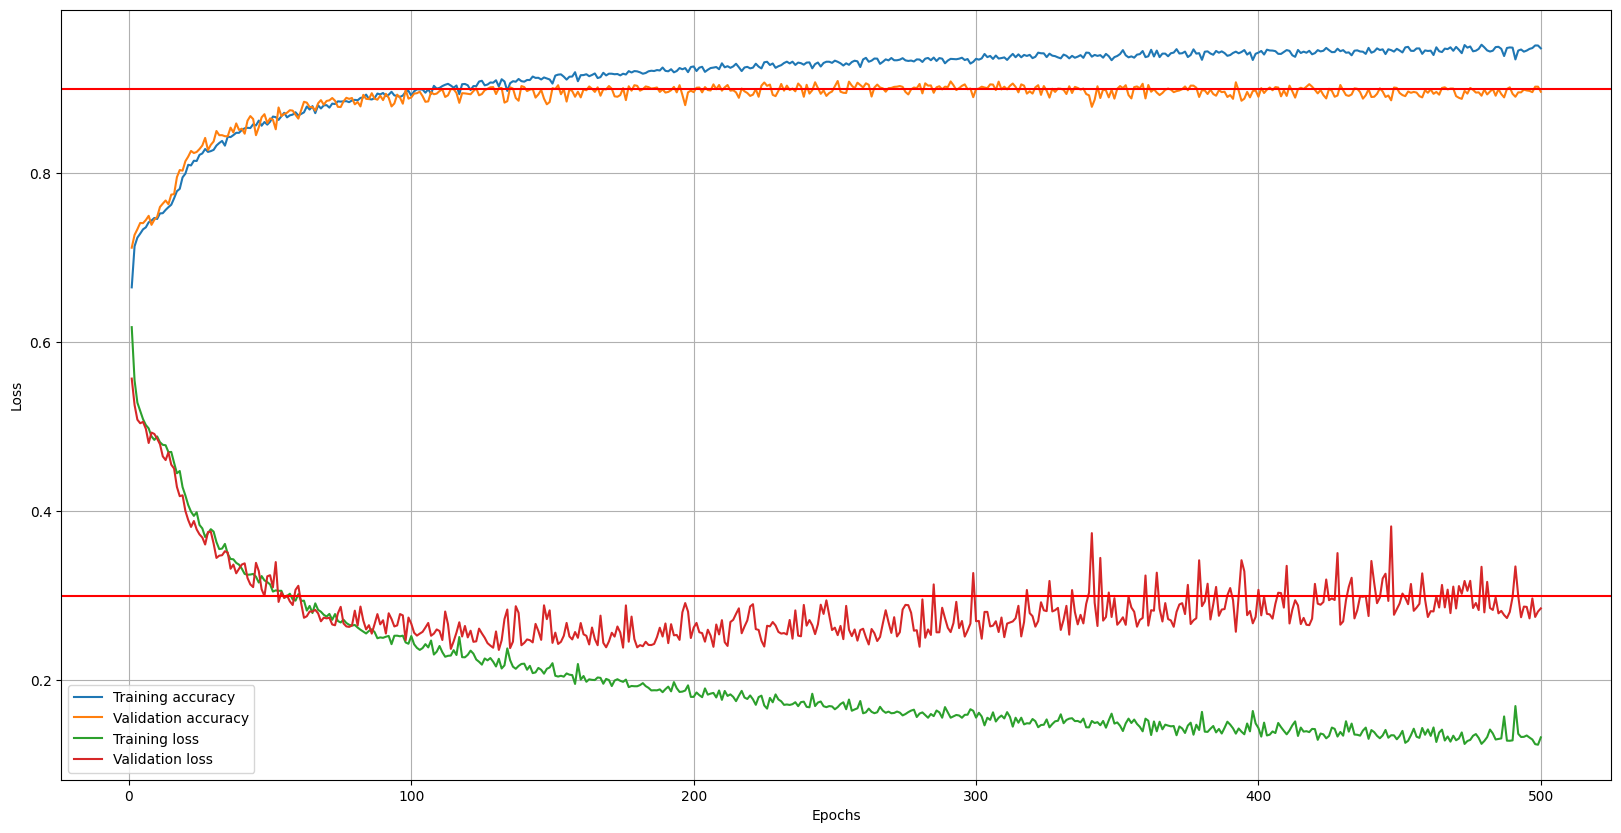

In [17]:
# Plot the training and validation loss and accuracy for each epoch for 1s partitions

training_accuracy = history.history['accuracy']
val_accuracy=history.history['val_accuracy']
training_loss = history.history['loss']
val_loss=history.history['val_loss']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
plt.figure(figsize=(20, 10))
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.axhline(y=0.9, color='r', linestyle='-')
plt.axhline(y=0.3, color='r', linestyle='-')

plt.grid()
# plt.ylim(0,1)
# plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

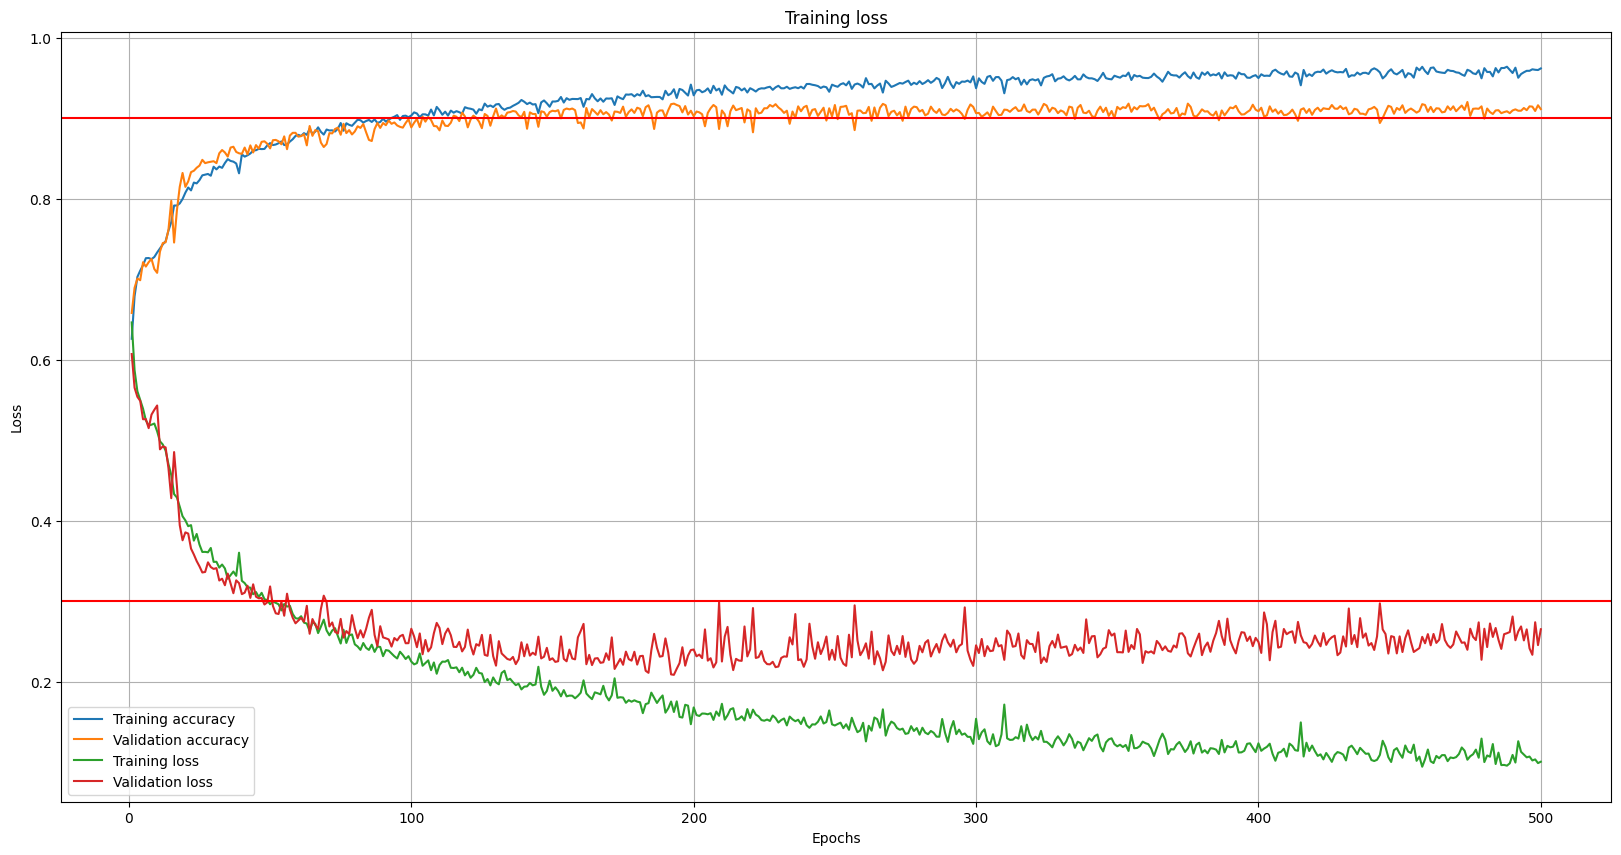

In [42]:
# Plot the training and validation loss and accuracy for each epoch for 4s partitions
with open('history_for_4s_best_1.jason','r') as f:
    history_1 = pd.read_json(f)

training_accuracy = history_1['accuracy']
val_accuracy=history_1['val_accuracy']
training_loss = history_1['loss']
val_loss=history_1['val_loss']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
plt.figure(figsize=(20, 10))
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')

plt.axhline(y=0.3, color='r', linestyle='-')

plt.axhline(y=0.9, color='r', linestyle='-')
plt.grid()
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()